In [2]:
import sys
import logging
from logging import getLogger
from recbole.utils import init_logger, init_seed
from Modules.mamba4poi import Mamba4POI
from recbole.config import Config
from utils import *
from recbole.trainer import Trainer
from recbole.data.transform import construct_transform
from recbole.utils import (
    init_logger,
    get_model,
    get_trainer,
    init_seed,
    set_color,
    get_flops,
    get_environment,
)
import torch
from Modules.myutils import * 

config = Config(model=Mamba4POI, config_file_list=['config.yaml'])
dataset = create_dataset(config)
train_data,valid_data,test_data = data_preparation(config, dataset)


In [16]:
t=config['TIME_FIELD']+config['LIST_SUFFIX']

In [18]:
for batch in train_data:
    print(batch[t].shape)
    break

torch.Size([2048, 32])


In [20]:
import re
import matplotlib.pyplot as plt

def extract_metrics_from_log(log_file):
    # 初始化指标
    epochs = []
    train_losses = []
    valid_scores = []
    recall_1 = []
    recall_5 = []
    recall_10 = []
    recall_20 = []
    mrr_1 = []
    mrr_5 = []
    mrr_10 = []
    mrr_20 = []
    ndcg_1 = []
    ndcg_5 = []
    ndcg_10 = []
    ndcg_20 = []
    current_epoch = -1
    with open(log_file, 'r') as file:
        lines = file.readlines()
        
        for line in lines:
            # 提取训练损失和验证得分
            train_loss_match = re.search(r'train loss: ([\d\.]+)', line)
            if train_loss_match:
                train_losses.append(float(train_loss_match.group(1)))

            valid_score_match = re.search(r'valid_score: ([\d\.]+)', line)
            if valid_score_match:
                valid_scores.append(float(valid_score_match.group(1)))

            # 提取 recall、mrr、ndcg 等指标
            result_match = re.search(r'recall@1 : ([\d\.]+).*?recall@5 : ([\d\.]+).*?recall@10 : ([\d\.]+).*?recall@20 : ([\d\.]+).*?mrr@1 : ([\d\.]+).*?mrr@5 : ([\d\.]+).*?mrr@10 : ([\d\.]+).*?mrr@20 : ([\d\.]+).*?ndcg@1 : ([\d\.]+).*?ndcg@5 : ([\d\.]+).*?ndcg@10 : ([\d\.]+).*?ndcg@20 : ([\d\.]+)', line)
            if result_match:
                recall_1.append(float(result_match.group(1)))
                recall_5.append(float(result_match.group(2)))
                recall_10.append(float(result_match.group(3)))
                recall_20.append(float(result_match.group(4)))
                mrr_1.append(float(result_match.group(5)))
                mrr_5.append(float(result_match.group(6)))
                mrr_10.append(float(result_match.group(7)))
                mrr_20.append(float(result_match.group(8)))
                ndcg_1.append(float(result_match.group(9)))
                ndcg_5.append(float(result_match.group(10)))
                ndcg_10.append(float(result_match.group(11)))
                ndcg_20.append(float(result_match.group(12)))

              # 提取 epoch 信息，避免重复记录
            epoch_match = re.search(r'INFO  epoch (\d+)', line)
            if epoch_match:
                epoch = int(epoch_match.group(1))
                if epoch != current_epoch:  # 如果当前epoch和上一条记录的epoch不同，才记录
                    epochs.append(epoch)
                    current_epoch = epoch
                
    return {
        'epochs': epochs,
        'train_losses': train_losses,
        'valid_scores': valid_scores,
        'recall_1': recall_1,
        'recall_5': recall_5,
        'recall_10': recall_10,
        'recall_20': recall_20,
        'mrr_1': mrr_1,
        'mrr_5': mrr_5,
        'mrr_10': mrr_10,
        'mrr_20': mrr_20,
        'ndcg_1': ndcg_1,
        'ndcg_5': ndcg_5,
        'ndcg_10': ndcg_10,
        'ndcg_20': ndcg_20,
    }

def plot_metrics(metrics,title):
    # 绘制训练损失和验证得分
    plt.figure(figsize=(15, 10))

    # 训练损失
    plt.subplot(2, 2, 1)
    plt.plot(metrics['epochs'], metrics['train_losses'], label='Train Loss', marker='o', markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Train Loss')
    plt.title('Train Loss')
    plt.grid(True)

    # 验证得分
    plt.subplot(2, 2, 2)
    plt.plot(metrics['epochs'], metrics['valid_scores'], label='Valid Score', marker='o', markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Valid Score')
    plt.title('Valid Score')
    plt.grid(True)

    # 绘制Recall@1, Recall@5, Recall@10, Recall@20
    plt.subplot(2, 2, 3)
    plt.plot(metrics['epochs'], metrics['recall_1'], label='Recall@1', marker='o', markersize=4)
    plt.plot(metrics['epochs'], metrics['recall_5'], label='Recall@5', marker='o', markersize=4)
    plt.plot(metrics['epochs'], metrics['recall_10'], label='Recall@10', marker='o', markersize=4)
    plt.plot(metrics['epochs'], metrics['recall_20'], label='Recall@20', marker='o', markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('Recall')
    plt.title('Recall@1, Recall@5, Recall@10, Recall@20')
    plt.legend()
    plt.grid(True)

    # 绘制MRR@1, MRR@5, MRR@10, MRR@20
    plt.subplot(2, 2, 4)
    plt.plot(metrics['epochs'], metrics['mrr_1'], label='MRR@1', marker='o', markersize=4)
    plt.plot(metrics['epochs'], metrics['mrr_5'], label='MRR@5', marker='o', markersize=4)
    plt.plot(metrics['epochs'], metrics['mrr_10'], label='MRR@10', marker='o', markersize=4)
    plt.plot(metrics['epochs'], metrics['mrr_20'], label='MRR@20', marker='o', markersize=4)
    plt.xlabel('Epoch')
    plt.ylabel('MRR')
    plt.title('MRR@1, MRR@5, MRR@10, MRR@20')
    plt.legend()
    plt.grid(True)

    # 显示图表
    plt.tight_layout()
    plt.suptitle(title, fontsize=16, fontweight='bold')

    # 调整布局以避免标题与子图重叠
    plt.tight_layout()
    
    # 显示图表
    plt.show()




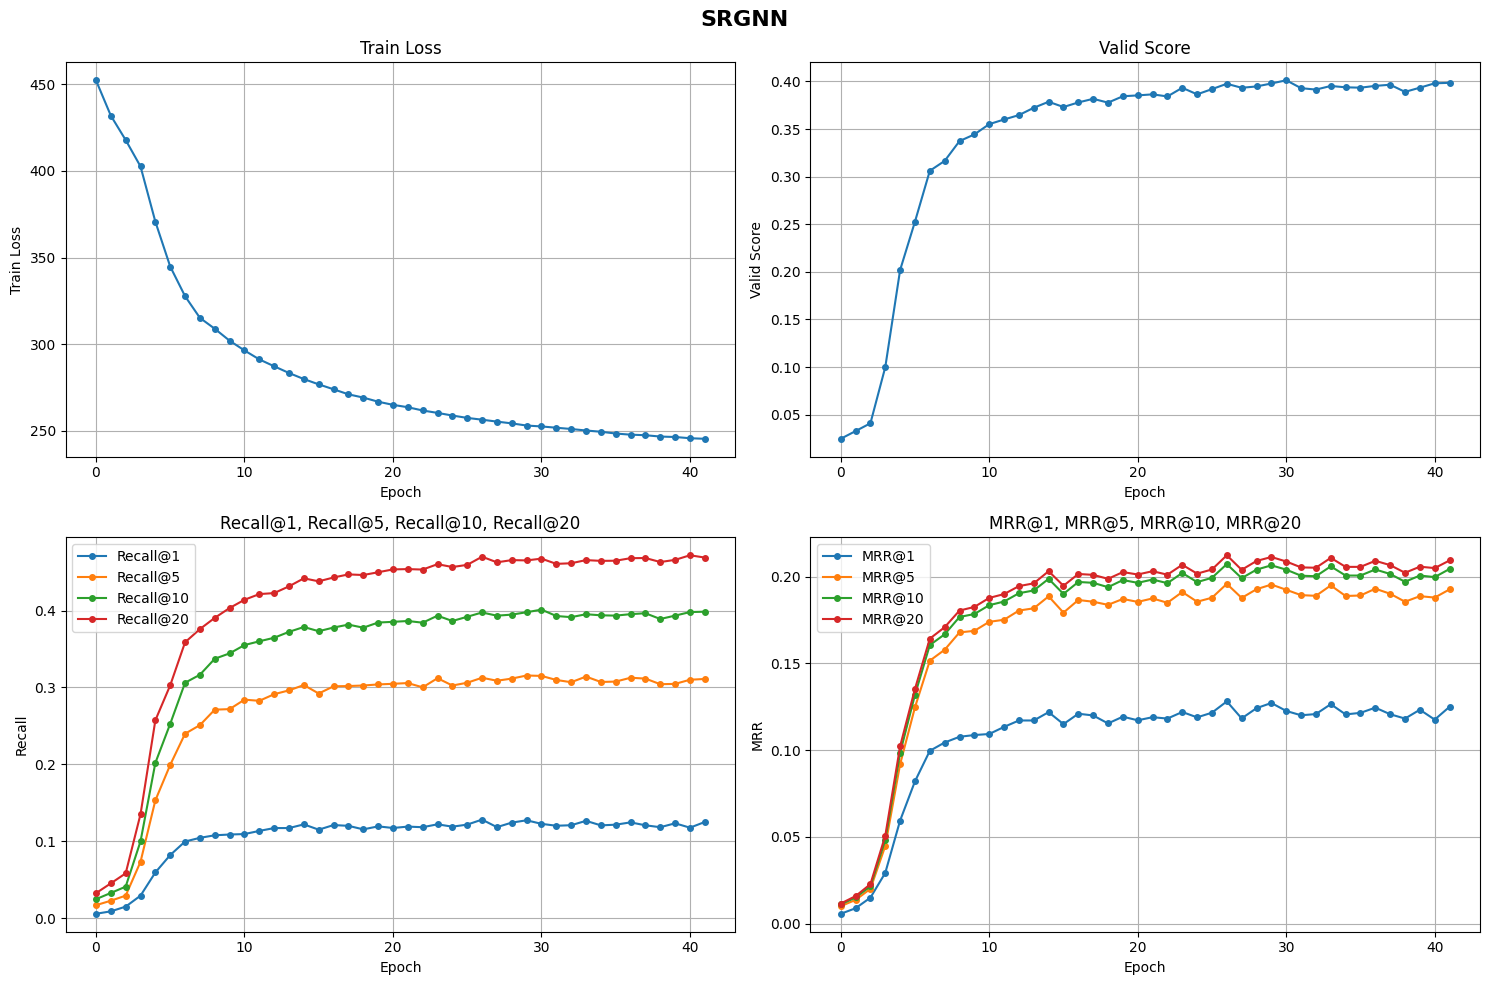

In [21]:
log_file_path = '/mnt/nvme0n1p2/Files/Code/Mamba/Mamba4POI/log/SRGNN/log.log'  # 替换为你的日志文件路径
SRGNNmetrics = extract_metrics_from_log(log_file_path)
title='SRGNN'
plot_metrics(SRGNNmetrics,title)

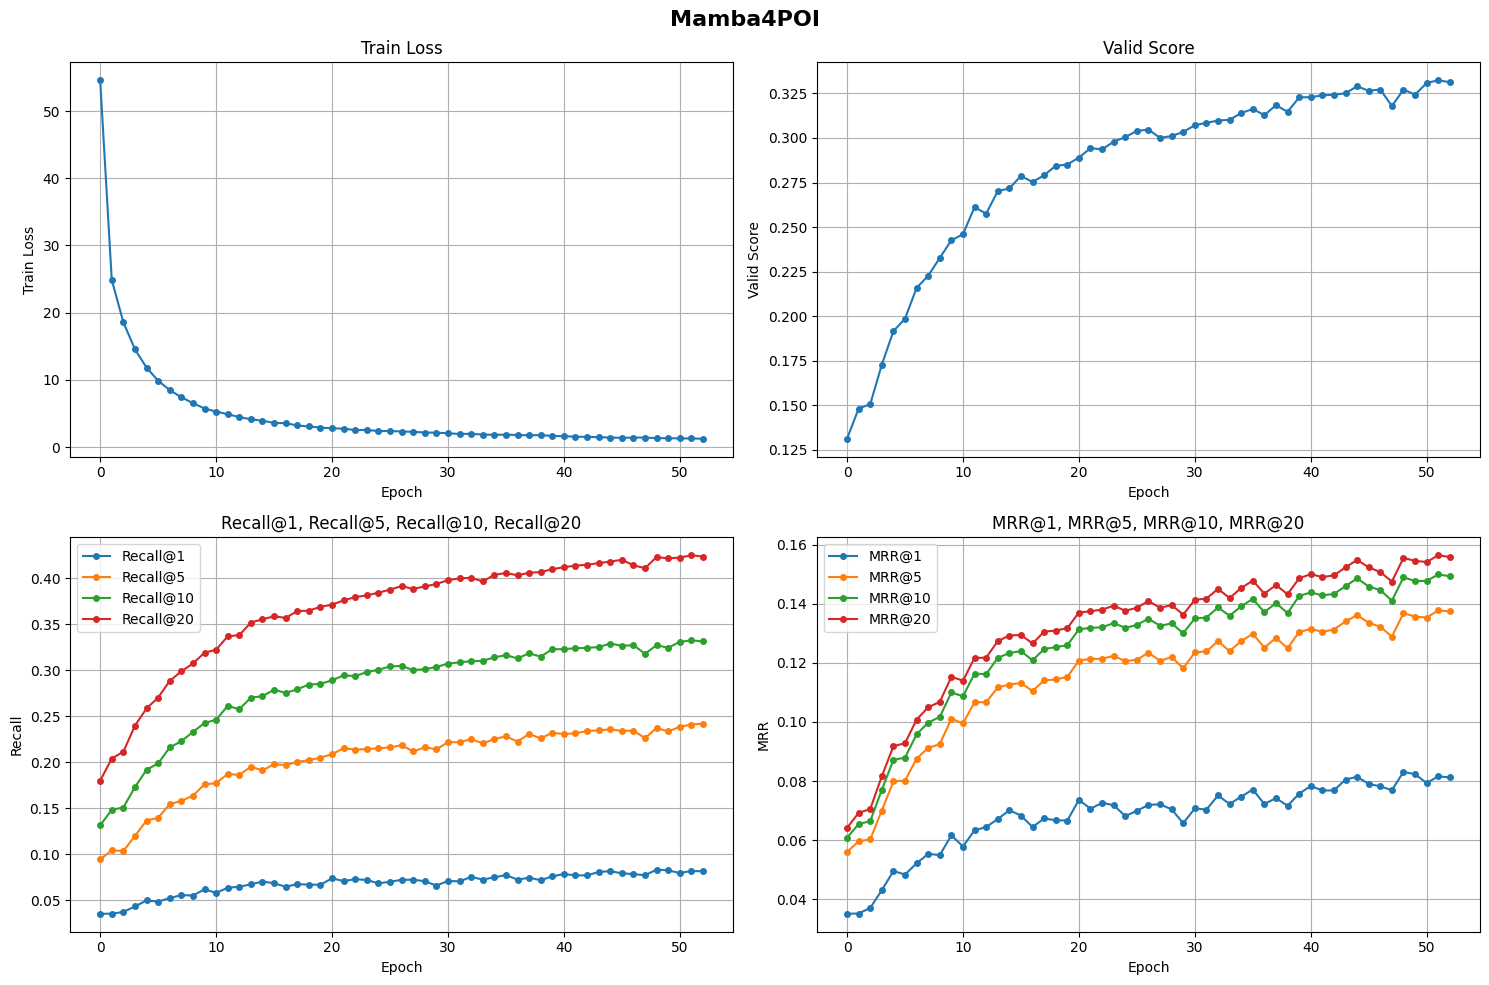

In [22]:
log_file_path = '/mnt/nvme0n1p2/Files/Code/Mamba/Mamba4POI/log/Mamba4POI/log.log'  # 替换为你的日志文件路径
MambaMetrics = extract_metrics_from_log(log_file_path)
title='Mamba4POI'
plot_metrics(MambaMetrics,title)